In [2]:
import sys 
sys.path.append('../')

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import seaborn as sns
import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

sns.set(style='whitegrid')
import matplotlib
matplotlib.rcParams["figure.dpi"] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

#### Imports

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import wandb

import tqdm
import pickle
import pytorch_lightning as pl
import random

from torch.utils.data import IterableDataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from functools import partial
from collections import namedtuple
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [4]:
from src.transactions_qa.tqa_model import TransactionQAModel
from src.models.components.models import TransactionsModel
from src.utils.tools import (make_time_batch, 
                   calculate_embedding_size)

from src.data.alfa.components import ( 
                             cat_features_names, 
                             num_features_names, 
                             meta_features_names)

from src.data import AlfaDataModule 
from src.transactions_qa.tqa_model import TransactionQAModel
from src.transactions_qa.utils import get_projections_maps, get_exponent_number, get_mantissa_number
from src.tasks import AbstractTask, AutoTask
from src.transactions_qa.utils import get_split_indices,  prepare_splitted_batch, collate_batch_dict

In [5]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, AutoConfig

In [6]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [7]:
def load_transaction_model(encoder_type='whisper/tiny', head_type='next'):
    projections_maps = get_projections_maps(relative_folder="..")
    # Loading Transactions model & weights
    print(f"Loading Transactions model...")

    transactions_model_encoder_type = encoder_type
    transactions_model_head_type = head_type


    transactions_model_config = {
        "cat_features": cat_features_names,
        "cat_embedding_projections": projections_maps.get('cat_embedding_projections'),
        "num_features": num_features_names,
        "num_embedding_projections": projections_maps.get('num_embedding_projections'),
        "meta_features": meta_features_names,
        "meta_embedding_projections": projections_maps.get('meta_embedding_projections'),
        "encoder_type": transactions_model_encoder_type,
        "head_type": transactions_model_head_type,
        "embedding_dropout": 0.1
    }
    transactions_model = TransactionsModel(**transactions_model_config)

    return transactions_model, projections_maps

In [8]:
def load_language_model(language_model_name_or_path="google/flan-t5-small"):
    use_fast_tokenizer = True

    print(f"Loading Language model: `{language_model_name_or_path}`...")
    config_kwargs = {
        "use_auth_token": None,
        "return_unused_kwargs": True
    }

    tokenizer_kwargs = {
        "use_fast": use_fast_tokenizer,
        "use_auth_token": None,
        "do_lowercase": False
    }

    config, unused_kwargs = AutoConfig.from_pretrained(
        language_model_name_or_path, **config_kwargs
    )
    # Download vocabulary from huggingface.co and define model-specific arguments
    tokenizer = AutoTokenizer.from_pretrained(language_model_name_or_path, **tokenizer_kwargs)

    # Download model from huggingface.co and cache.
    lm_model = AutoModelForSeq2SeqLM.from_pretrained(
        language_model_name_or_path,
        config=config
    )
    return lm_model, tokenizer

In [9]:
def load_datamodule():
    DATA_PATH = '/home/jovyan/romashka/data' 
    dataset_config = {
                'data_dir': DATA_PATH,
                'batch_size': 32,
                'min_seq_len': 0,
                'max_seq_len': 250,
                'shuffle': True,
                'num_workers': 5,
                'pin_memory': True,
                'seed': 42
    }    

    dm = AlfaDataModule(**dataset_config)
    return dm

In [34]:
def load_tasks(task_names, tokenizer):
    # Create tasks
    tasks = []
    tasks_kwargs = [{"num_options": 6, "floating_threshold": False, 'answer2text': True, 'use_numerical_output': False}, 
    {"num_options": 6, "floating_threshold": False, 'use_numerical_output': False}] # ground truth + 5 additional options
    if isinstance(task_names, str):
        task_names = eval(task_names)
    if isinstance(tasks_kwargs, str):
        tasks_kwargs = eval(tasks_kwargs)
    print(f"Got task_names: {task_names} with task_kwargs: {tasks_kwargs}")

    for task_i, task_name in enumerate(task_names):
        task_kwargs = tasks_kwargs[task_i] if task_i < len(tasks_kwargs) else {}
        if "tokenizer" not in task_kwargs:
            task_kwargs['tokenizer'] = tokenizer
        task = AutoTask.get(task_name=task_name, **task_kwargs)
        tasks.append(task)
    print(f"Created {len(tasks)} tasks.")
    return tasks

In [35]:
def make_tqa_model(lm_model, transactions_model, tokenizer, tasks):
    # Create general Tranactions QA model
    max_steps = 100_000
    warmup_steps = 1000
    do_freeze_transactions_model = True
    do_freeze_language_model = True
    do_freeze_connector = False

    transactionsQA_model_config = {
        "warmup_steps": warmup_steps,
        "training_steps": max_steps,
        "do_freeze_tm": do_freeze_transactions_model,
        "do_freeze_lm": do_freeze_language_model,
        "do_freeze_connector": do_freeze_connector,
        "connector_input_size": 384,
        "use_numerical_input": False,
        "use_numerical_output": False,
        "numerical_context": "context",
    }

    model = TransactionQAModel(
        language_model=lm_model,
        transaction_model=transactions_model,
        tokenizer=tokenizer,
        tasks=tasks,
        **transactionsQA_model_config
    )
    return model

In [36]:
# task_names = ['next_transactions_30_days_binary', 'default', 'next_mcc_binary', 'next_mcc_open_ended']
task_names = ['next_amnt_open_ended']
LM_NAME = 'google/flan-t5-small'

lm_model, tokenizer = load_language_model(language_model_name_or_path=LM_NAME)
transactions_model, projections_maps = load_transaction_model()

tasks = load_tasks(task_names, tokenizer)
dm = load_datamodule()

tqa_model = make_tqa_model(lm_model, transactions_model, tokenizer, tasks)

Loading Language model: `google/flan-t5-small`...
Loading Transactions model...


2023-06-15 15:46:32,637 - [INFO] - Tasks - (task_abstract.py).generate_question_templates(206) - Given 5 starting options and 1 ending options results in 5 total combinations.
2023-06-15 15:46:32,639 - [INFO] - Tasks - (task_abstract.py).extend_vocabulary(173) - Added to tokenizer: 2 tokens.
2023-06-15 15:46:32,640 - [INFO] - Tasks - (task_abstract.py).extend_vocabulary(179) - Notice: resize_token_embeddings of a model to adapt to the size of the new vocabulary!
2023-06-15 15:46:32,659 - [INFO] - TransactionQAModel - (tqa_model.py).__init__(113) - Setuping metrics.
2023-06-15 15:46:32,659 - [INFO] - TransactionQAModel - (tqa_model.py).__init__(113) - Setuping metrics.
2023-06-15 15:46:32,659 - [INFO] - TransactionQAModel - (tqa_model.py).__init__(113) - Setuping metrics.
2023-06-15 15:46:32,664 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(206) - Running in `single task` settingwith a single task: next_amnt_open_ended provided.
2023-06-15 15:46:32,664 - [INFO] - Transac

USING whisper
Got task_names: ['next_amnt_open_ended'] with task_kwargs: [{'num_options': 6, 'floating_threshold': False, 'answer2text': True, 'use_numerical_output': False}, {'num_options': 6, 'floating_threshold': False, 'use_numerical_output': False}]
Created 1 tasks.
Output dimension of embedding model: 384
Input dimension of autoregressive model: 512
Creating linear connector from 384 to 512 and move to device: cpu.
ModuleDict(
  (next_amnt_open_ended): ModuleDict(
    (mae): MeanAbsoluteError()
    (mape): MeanAbsolutePercentageError()
    (rouge): ROUGEScore()
  )
)


2023-06-15 15:46:32,968 - [INFO] - TransactionQAModel - (tqa_model.py)._resize_text_embeddings(263) - LM resized `num_embeddings`: 32102, `embedding_dim`: 512
2023-06-15 15:46:32,968 - [INFO] - TransactionQAModel - (tqa_model.py)._resize_text_embeddings(263) - LM resized `num_embeddings`: 32102, `embedding_dim`: 512
2023-06-15 15:46:32,968 - [INFO] - TransactionQAModel - (tqa_model.py)._resize_text_embeddings(263) - LM resized `num_embeddings`: 32102, `embedding_dim`: 512
2023-06-15 15:46:32,974 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(217) - Freezing transaction model's parameters...
2023-06-15 15:46:32,974 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(217) - Freezing transaction model's parameters...
2023-06-15 15:46:32,974 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(217) - Freezing transaction model's parameters...
2023-06-15 15:46:32,977 - [INFO] - TransactionQAModel - (tqa_model.py)._prepare_model(222) - Freezing language mode

In [37]:
# ckpt = torch.load('/home/jovyan/romashka/checkpoints/checkpoints/tqa_200k-steps_ft=all_numerical_v5/last.ckpt')['state_dict']

# tqa_model.load_state_dict(ckpt, strict=False)
# tqa_model.cuda();

### Numerical Input

In [44]:
import re
from src.models.components.embedding import NumEmbedding

In [45]:
batch = next(iter(dm.val_dataloader()))

In [46]:
pred = tqa_model.model_step(batch)

In [50]:
pred[0]['label']

tensor([0.4800, 0.4700, 0.6500, 0.4800, 0.5200, 0.4400, 0.5400, 0.5300, 0.2600,
        0.5200, 0.4400, 0.5400, 0.4800, 0.5000, 0.5200, 0.4900, 0.5300, 0.3500,
        0.5000, 0.4500, 0.4400, 0.3200, 0.4100, 0.4800, 0.4700, 0.3800, 0.4900,
        0.5200, 0.4100, 0.2600, 0.5500, 0.4500])

In [40]:
# tqa_model.validation_step(batch, 0)

Validation predictions vs. answers, batch #0:
	#0:	predicted: 1 not transactions, answer: zero dot four eight
	#1:	predicted:  not transactions, answer: zero dot four seven
	#2:	predicted: 1 not  transactions, answer: zero dot six five
	#3:	predicted: 1 not transactions, answer: zero dot four eight
	#4:	predicted: 1 not transactions, answer: zero dot five two
	#5:	predicted: 1 not transactions, answer: zero dot four four
	#6:	predicted: 1 not transactions, answer: zero dot five four
	#7:	predicted: 1 not transactions, answer: zero dot five three
	#8:	predicted: 1 not  transactions, answer: zero dot two six
	#9:	predicted: 1 not transactions, answer: zero dot five two
	#10:	predicted: 1 not  transactions, answer: zero dot four four
	#11:	predicted: 1 not  transactions, answer: zero dot five four
	#12:	predicted: 1 nots transactions, answer: zero dot four eight
	#13:	predicted: 1 not transactions, answer: zero dot five
	#14:	predicted: 1 not transactions, answer: zero dot five two
	#15:	

/home/jovyan/.imgenv-afilatov-dev-19-0/lib/python3.7/site-packages/pytorch_lightning/core/module.py:417: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  "You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet."


tensor(9.9947, grad_fn=<NllLossBackward0>)

In [19]:
tmp = tqa_model.tasks[0].prepare_task_batch(batch)
# tmp2 = tqa_model.tasks[0].process_input_batch(batch)

In [21]:
tmp['label']

tensor([0.5200, 0.4700, 0.5200, 0.4000, 0.5000, 0.4300, 0.5100, 0.5400, 0.4600,
        0.5200, 0.3600, 0.5500, 0.4500, 0.5000, 0.2800, 0.4800, 0.5200, 0.5000,
        0.5000, 0.4500, 0.4400, 0.2600, 0.4600, 0.4600, 0.4200, 0.2600, 0.4900,
        0.3700, 0.4400, 0.4500, 0.5500, 0.4500])

In [47]:
torch.randn(10)[0]

tensor(0.8523)

In [33]:
tmp['threshold']

tensor([[0.3600],
        [0.5700],
        [0.5800],
        [0.0400],
        [0.7900],
        [0.8800],
        [0.4900],
        [0.3300],
        [0.4900],
        [0.1000],
        [0.6900],
        [0.8600],
        [0.8400],
        [0.0700],
        [0.7500],
        [0.2400],
        [0.4700],
        [0.6400],
        [0.9800],
        [0.6600],
        [0.0800],
        [0.5000],
        [0.6800],
        [0.7600],
        [0.3600],
        [0.3200],
        [0.4300],
        [0.4800],
        [0.3700],
        [0.2600],
        [0.1300],
        [0.0900]])

In [17]:
trx_index = batch['mask'].sum(1, keepdim=True) - 1
t = batch['num_features'][0]

In [20]:
outputs, batch_answers = tqa_model.model_step(batch, task_idx=0)

In [21]:
tqa_model.tasks[0].process_outputs(outputs, batch_answers)[1].shape

torch.Size([32])

In [22]:
metrics_scores = tqa_model.tasks[0].calculate_metrics(outputs, batch_answers, tqa_model.val_metrics[tqa_model.tasks[0].task_name], stage='val_')

#### Transform numbers to text

In [46]:
import inflect

In [47]:
p = inflect.engine()

In [48]:
words = p.number_to_words(123.456,  decimal="dot")

In [49]:
new_batch = tqa_model.tasks[0].process_input_batch(batch)
qa_batch = tqa_model.tokenize_texts(new_batch)

In [52]:
# new_batch['question_end_string']

In [57]:
num_values = [re.findall("\d+\.\d+", question) for question in new_batch['question_end_string']]

text_arrays = []
for numbers in num_values:
    text_rows = []
    for number in numbers:
        text_rows.append(p.number_to_words(number, decimal="dot"))
    
    text_arrays.append(text_rows)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_35565/1405876172.py:1: DeprecationWarning: invalid escape sequence \d
  num_values = [re.findall("\d+\.\d+", question) for question in new_batch['question_end_string']]


In [70]:
numerics = [re.sub("\d+\.\d+", lambda x: p.number_to_words(x.string[x.start():x.end()], decimal='dot'), string) for string in new_batch['question_end_string']]

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_35565/3848032820.py:1: DeprecationWarning: invalid escape sequence \d
  numerics = [re.sub("\d+\.\d+", lambda x: p.number_to_words(x.string[x.start():x.end()], decimal='dot'), string) for string in new_batch['question_end_string']]


In [71]:
numerics

['[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',
 '[/trx]. Will the next transactions have amount more than zero dot four one? Yes or No?',

In [51]:
# qa_batch['question_end_tokens'] == tqa_model.input_num_token

In [129]:
num_values = [re.findall("\d+\.\d+", question) for question in new_batch['question_end_string']]
numerics = [re.sub("\d+\.\d+", '<extra_id_0>', string) for string in new_batch['question_end_string']]

# numerical_mask = (question_end_embeddings_batch['question_end_tokens'] == self.input_num_token)

values = []
for value_list in num_values:
    for value in value_list:
        values.append(float(value))

# values = torch.tensor(values)
values = torch.randn(32)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_29241/3952724340.py:1: DeprecationWarning: invalid escape sequence \d
  num_values = [re.findall("\d+\.\d+", question) for question in new_batch['question_end_string']]
/tmp/ipykernel_29241/3952724340.py:2: DeprecationWarning: invalid escape sequence \d
  numerics = [re.sub("\d+\.\d+", '<extra_id_0>', string) for string in new_batch['question_end_string']]


In [120]:
numerical_mask = (qa_batch['question_end_tokens'] == tqa_model.input_num_token)

In [115]:
buckets = torch.linspace(1, 10, steps=20)
numemb = NumEmbedding(512, buckets)

In [116]:
res = tqa_model.language_model.encoder.embed_tokens(qa_batch['question_end_tokens']) 

In [123]:
res[numerical_mask] += numemb(values)

In [112]:
# tqa_model.test_metrics.cuda();

In [113]:
diffs = []
with torch.no_grad():
    for batch in tqdm.tqdm(dm.val_dataloader()):
        tqa_model.eval()
        new_batch = {}
        for key, value in batch.items():
            new_batch[key] = batch[key].to('cuda')
        res = tqa_model.model_step(new_batch)
        diffs.extend(torch.abs(res[0]['preds'] - res[0]['label']).tolist())
        metrics_scores = tqa_model.tasks[0].calculate_metrics(res[0], res[1], tqa_model.test_metrics[tasks[0].task_name], stage='test_')

1811it [01:14, 24.40it/s]


### Resaving

In [ ]:
ckpt = torch.load('/home/jovyan/romashka/logs/train/runs/2023-05-16_16-42-51/checkpoints/epoch_013.ckpt')['state_dict']new_dict = {}
for key in ckpt:
    filter_start = len('_seq_encoder.full_model.')
    if 'full_model'in key:
        new_dict[key[filter_start:]] = ckpt[key]
# torch.save(new_dict, 'coles_whisper_tiny.ckpt')
# transactions_model.load_state_dict(new_dict, strict=False)

### Debugging numerical context

In [89]:
batch = next(iter(dm.train_dataloader()))

In [90]:
# transactions_model

In [91]:
# outputs, answers = tqa_model.model_step(batch)
output, answer = tqa_model.model_step(batch)

In [92]:
from einops import einsum, rearrange, repeat

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

class Attention(nn.Module):
    def __init__(self, query_dim, context_dim = None, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head * heads
        context_dim = default(context_dim, query_dim)

        self.scale = dim_head ** -0.5
        self.heads = heads

        self.to_q = nn.Linear(query_dim, inner_dim, bias = False)
        self.to_kv = nn.Linear(context_dim, inner_dim * 2, bias = False)

        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, query_dim)

    def forward(self, x, context = None, mask = None):
        h = self.heads

        q = self.to_q(x)
        context = default(context, x)
        k, v = self.to_kv(context).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h = h), (q, k, v))

        sim = einsum(q, k, 'b i d, b j d -> b i j') * self.scale

        if exists(mask):
            mask = rearrange(mask, 'b ... -> b (...)')
            max_neg_value = -torch.finfo(sim.dtype).max
            mask = repeat(mask, 'b j -> (b h) () j', h = h)
            sim.masked_fill_(mask==0, max_neg_value)

        # attention, what we cannot get enough of
        attn = sim.softmax(dim = -1)
        attn = self.dropout(attn)

        out = einsum(attn, v, 'b i j, b j d -> b i d')
        out = rearrange(out, '(b h) n d -> b n (h d)', h = h)
        return self.to_out(out)

In [128]:
num_context = Attention(512, 512, 1, 512)

In [94]:
context = output.encoder_last_hidden_state
x = output.decoder_hidden_states[-1]

In [130]:
num_token_mask = (answer == tqa_model.tokenizer.convert_tokens_to_ids('<NUM>')).any(dim=1)
embedding = output['decoder_hidden_states'][-1][num_token_mask]

context = output.encoder_last_hidden_state
embedding = num_context(embedding, context)

exponent = tqa_model.exponent_head(embedding)
mantissa = tqa_model.mantissa_head(embedding).squeeze(1)

In [127]:
lm_outputs['exponent'] = exponent
lm_outputs['mantissa'] = mantissa

# On our torch version torch.pow(10, 0) = 0, but torch.pow(10, 0.0) = 1 WTF
lm_outputs['preds'] = 10 ** (exponent.argmax(1).float() - 8) * mantissa
print(lm_outputs['preds'])
print('\n\n\n\n\n')

torch.Size([32, 1, 512])

In [63]:
result = m(x, context, mask=out.attention_mask)

In [65]:
result.shape

torch.Size([32, 1, 512])

In [17]:
outputs, answer = tqa_model.model_step(batch, task_idx=0)

loss = outputs.loss

if tqa_model.use_numerical:
    num_token_mask = (answer == tqa_model.tokenizer.convert_tokens_to_ids('<NUM>'))
    embedding = outputs['decoder_hidden_states'][-1][num_token_mask]

    exponent = tqa_model.exponent_head(embedding)
    mantissa = tqa_model.mantissa_head(embedding).squeeze(1)

    true_exponent = get_exponent_number(batch['label']).long() + 8
    true_mantissa = get_mantissa_number(batch['label'])

    mantissa_loss = tqa_model.mantissa_loss(mantissa / 10, true_mantissa / 10)
    exponent_loss = tqa_model.exponent_loss(exponent, true_exponent)
    loss += mantissa_loss + exponent_loss

In [29]:
true_number = 10 ** (true_exponent - 8) * true_mantissa


In [36]:
number = 10 ** (exponent.argmax(1) - 8) * mantissa

In [37]:
number

tensor([6.9237e-01, 1.0583e+07, 9.7010e+06, 9.1284e+06, 9.5233e+06, 8.7283e+06,
        7.1077e+06, 7.4372e-01, 8.6465e-01, 8.0990e+06, 7.5577e-01, 9.1483e+06,
        9.1172e+06, 8.3329e+06, 6.8024e+06, 8.1727e-01, 8.5900e+06, 1.0009e+07,
        8.7122e+06, 9.3413e+06, 9.2316e+06, 7.8789e+06, 6.3921e-01, 7.0747e+06,
        8.6757e-01, 8.4536e+06, 8.9018e+06, 8.2242e-01, 5.0791e-01, 9.8389e+06,
        8.8385e+06, 7.0208e-01], grad_fn=<MulBackward0>)

### Next 30 days transactions

In [17]:
transactions_30 = []

for batch in tqdm.tqdm(dm.train_dataloader(pl_training=False)):
    _, labels, _, padding_mask = make_time_batch(batch, number_days=30)
    trx_index = padding_mask.sum(1, keepdim=True) - 1
    
    ### This is the case when we don't have target so we skip this step
    if any(trx_index == -1):
        continue

    input_labels = torch.gather(labels, 1, trx_index).float().squeeze(1)
    transactions_30.extend(input_labels.tolist())

5322it [00:36, 145.20it/s]


KeyboardInterrupt: 

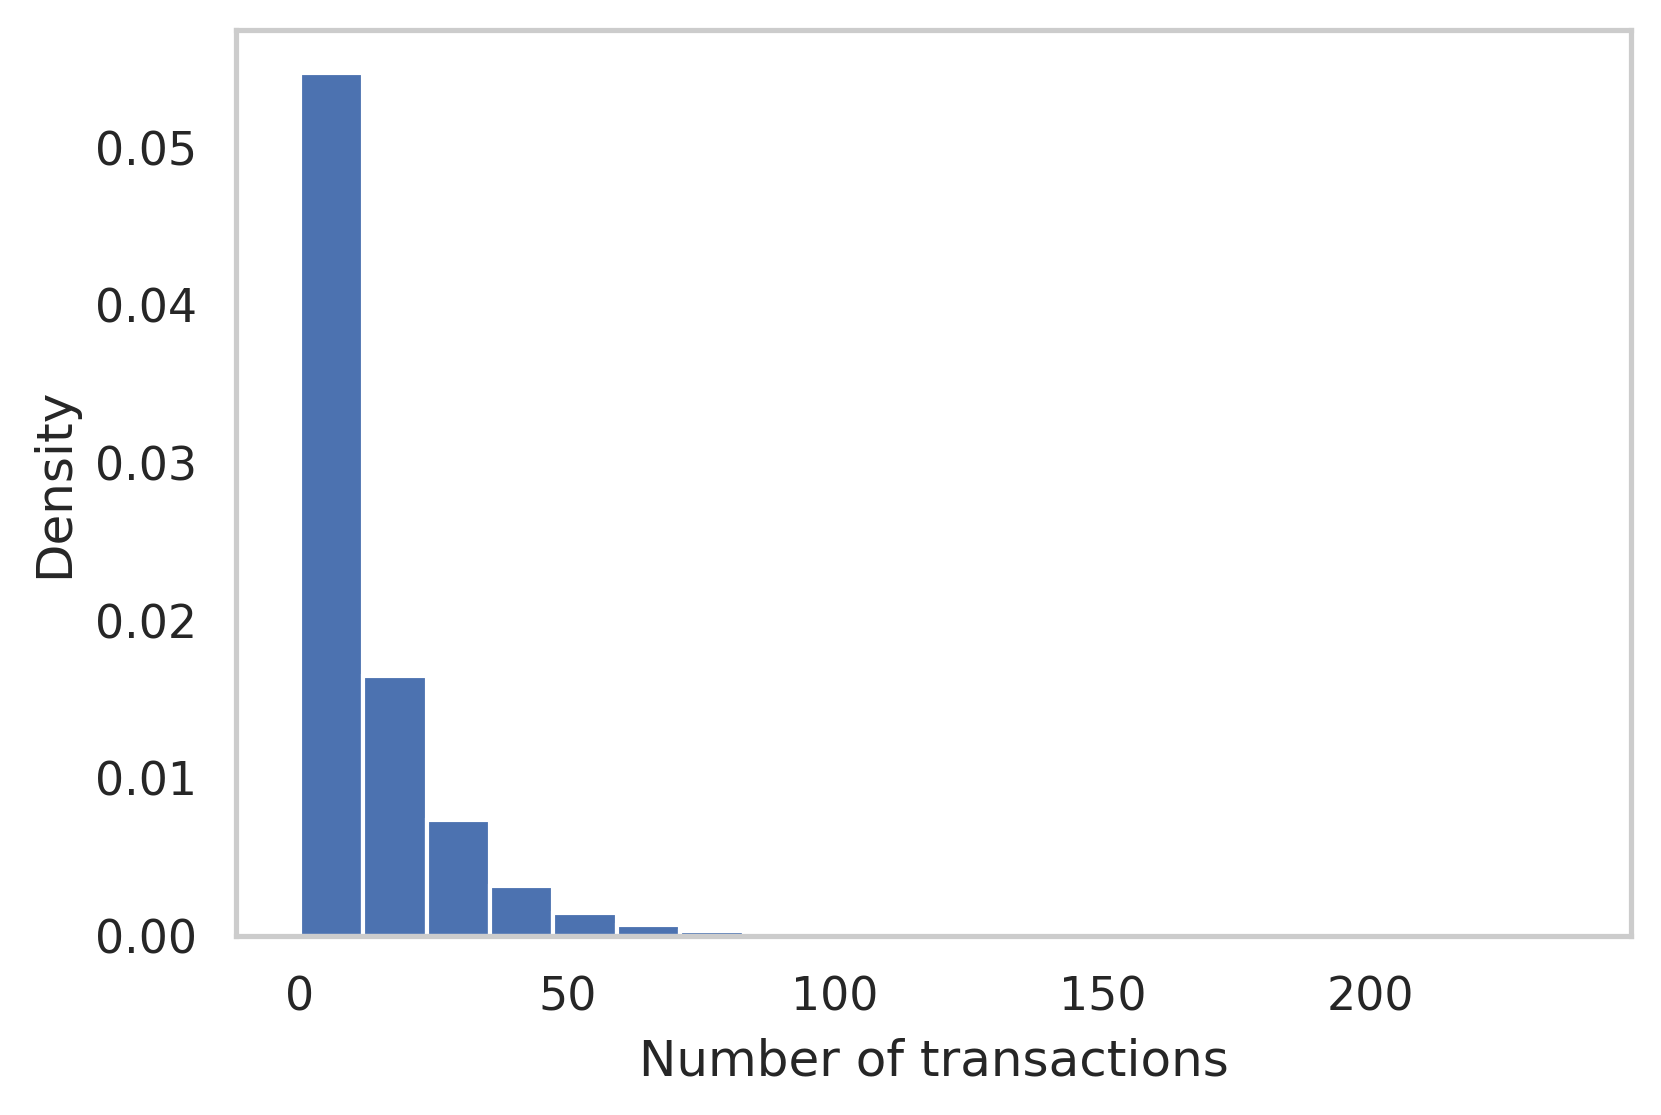

In [32]:
plt.hist(transactions_30, bins=20, density=True)
plt.xlabel('Number of transactions')
plt.ylabel('Density')
plt.grid()
plt.show()

In [34]:
np.quantile(transactions_30, 0.5)

6.0

#### Next amnt 30 days

In [18]:
targets = []
for batch in tqdm.tqdm(dm.val_dataloader()):
    trg = tqa_model.tasks[0].generate_target(batch)[0]
    if trg is not None:
        targets.extend(trg.tolist())

1811it [00:17, 103.64it/s]


In [19]:
np.mean(targets)

0.5346583946078431

In [35]:
amounts = []

for batch in tqdm.tqdm(dm.train_dataloader(pl_training=False)):
    labels, _, _, padding_mask = make_time_batch(batch, number_days=30)
    trx_index = padding_mask.sum(1, keepdim=True) - 1
    
    ### This is the case when we don't have target so we skip this step
    if any(trx_index == -1):
        continue

    input_labels = torch.gather(labels, 1, trx_index).float().squeeze(1)
    amounts.extend(input_labels.tolist())

16315it [02:56, 92.68it/s] 


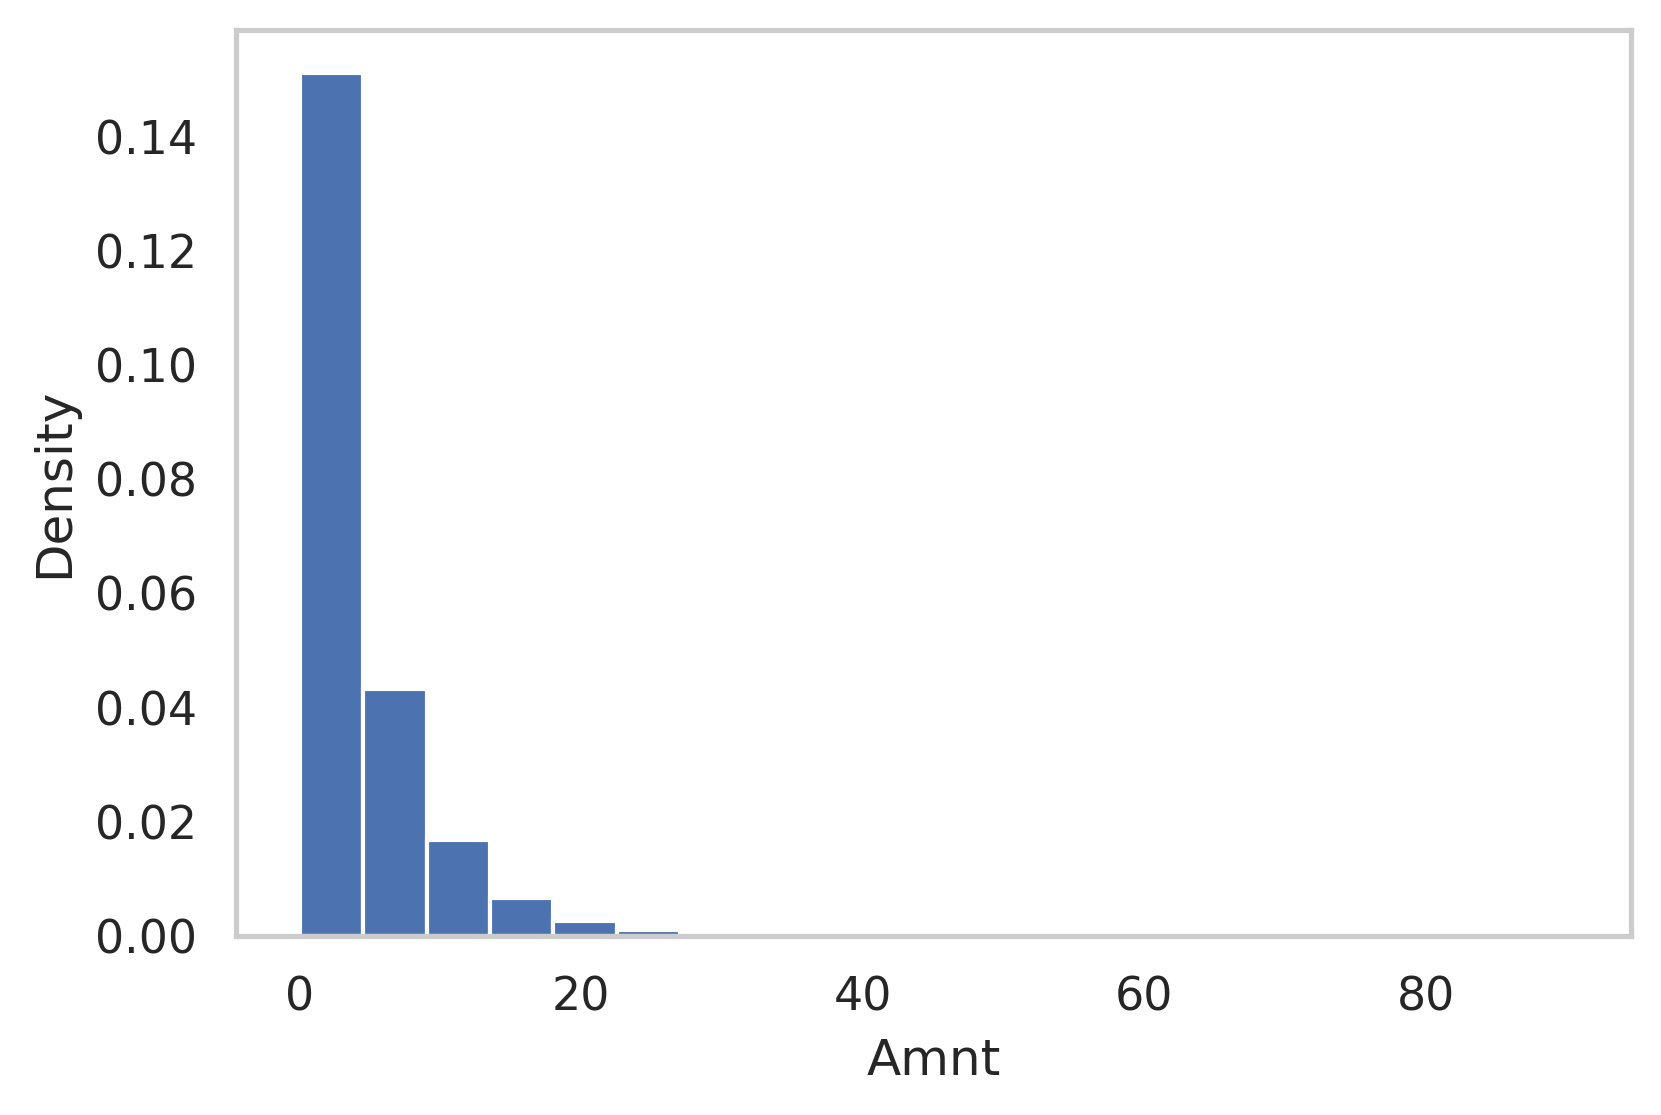

In [36]:
plt.hist(amounts, bins=20, density=True)
plt.xlabel('Amnt')
plt.ylabel('Density')
plt.grid()
plt.show()

In [39]:
np.quantile(amounts, 0.5)

2.2795541286468506

### Distributed DataLoader

Короче нужно вернуть старый итератор и сравнить сколько это по скорости работает?

In [11]:
from data_generators import batches_generator, old_batches_generator
from datasets import IterableDataset as HFIterableDataset
from pl_dataloader import TransactionQADataset
from torch.nn.utils.rnn import pad_sequence

In [6]:
%%time
for elem in tqdm.tqdm(old_batches_generator(dataset_train, batch_size=32, min_seq_len=50, max_seq_len=150)):
    pass

7392it [01:23, 89.03it/s] 

CPU times: user 16.1 s, sys: 39.2 s, total: 55.2 s
Wall time: 1min 23s


In [7]:
ds = TransactionQADataset(dataset_train, batch_size=1, max_seq_len=150, min_seq_len=50).build_dataset(buffer_size=None)
ds2 = TransactionQADataset(dataset_train, batch_size=2, max_seq_len=150, min_seq_len=50).build_dataset(buffer_size=None)

In [12]:
def collate_fn(batch):
    output = {}

    output['num_features'] = pad_sequence([d['num_features'].transpose(0, -1) for d in batch], batch_first=True).squeeze(2).permute(-1, 0, 1)
    output['cat_features'] = pad_sequence([d['cat_features'].transpose(0, -1) for d in batch], batch_first=True).squeeze(2).permute(-1, 0, 1)
    output['meta_features'] = torch.cat([d['meta_features'] for d in batch], dim=1)

    output['mask'] = pad_sequence([d['mask'].transpose(0, -1) for d in batch], batch_first=True).squeeze(2)
    output['app_id'] = torch.cat([d['app_id'] for d in batch])
    output['label'] = torch.cat([d['label'] for d in batch])

    return output

In [13]:
my_dl = DataLoader(ds, batch_size=32, num_workers=10, collate_fn=collate_fn)
my_dl2 = DataLoader(ds, batch_size=32, num_workers=1, collate_fn=collate_fn)
my_dl3 = DataLoader(ds2, batch_size=16, num_workers=10, collate_fn=collate_fn)

In [14]:
%%time
for elem in tqdm.tqdm(my_dl):
    pass

7336it [00:28, 257.34it/s]

CPU times: user 10.1 s, sys: 5.59 s, total: 15.7 s
Wall time: 28.5 s


In [23]:
# Download vocabulary from huggingface.co and define model-specific arguments
tokenizer = AutoTokenizer.from_pretrained('google/flan-t5-small')

config = AutoConfig.from_pretrained(
    'google/flan-t5-small',
)

# Download model from huggingface.co and cache.
lm_model = AutoModelForSeq2SeqLM.from_pretrained(
    'google/flan-t5-small',
    config=config
)

In [ ]:
transactions_model_config = {
    "cat_features": cat_features_names,
    "cat_embedding_projections": projections_maps.get('cat_embedding_projections'),
    "num_features": num_features_names,
    "num_embedding_projections": projections_maps.get('num_embedding_projections'),
    "meta_features": meta_features_names,
    "meta_embedding_projections": projections_maps.get('meta_embedding_projections'),
    "encoder_type": model_args.transactions_model_encoder_type,
    "head_type": model_args.transactions_model_head_type,
    "embedding_dropout": 0.1
}
transactions_model = TransactionsModel(**transactions_model_config)

In [ ]:
# Create general Tranactions QA model
transactionsQA_model_config = {
    "warmup_steps": 10,
    "training_steps": 1000,
    "do_freeze_tm": False,
    "do_freeze_lm": False,
    "do_freeze_connector": False,
    "connector_input_size": 384,
}
model = TransactionQAModel(
    language_model=lm_model,
    transaction_model=transactions_model,
    tokenizer=tokenizer,
    tasks=tasks,
    **transactionsQA_model_config
)

### Saving new data format

In [ ]:
path = dataset_train[0]

gc.disable()
with open(path, 'rb') as f:
    data = pickle.load(f)

gc.enable()

padded_sequences, targets, products = data['padded_sequences'], data['targets'], data[
    'products']
app_ids = data['app_id']
indices = np.arange(len(products))

transaction_features = ['currency', 'operation_kind', 'card_type', 'operation_type',
                        'operation_type_group', 'ecommerce_flag', 'payment_system',
                        'income_flag', 'mcc', 'country', 'city', 'mcc_category',
                        'day_of_week', 'hour', 'weekofyear', 'amnt', 'days_before', 'hour_diff']

num_features_names = ['amnt', 'days_before', 'hour_diff']
cat_features_names = [x for x in transaction_features if x not in num_features_names]
meta_features_names = ['product']

num_features_indices = [transaction_features.index(x) for x in num_features_names]
cat_features_indices = [transaction_features.index(x) for x in cat_features_names]


bucket = padded_sequences[0]
batch_sequences = bucket[0: 0 + 1]

new_data = {}

for key in data:
    for elem in data[key]:
        new_data[key] = to

                        ret = dict(num_features=[torch.FloatTensor(batch_sequences[:, i]) for i in num_features_indices],
                            cat_features=[torch.LongTensor(batch_sequences[:, i]) for i in cat_features_indices],
                            mask=torch.BoolTensor(mask),
                            meta_features=[torch.LongTensor(batch_products)],
                            app_id=torch.LongTensor(batch_app_ids)
                )

### Multi-task batch

In [96]:
from copy import deepcopy

In [97]:
batch1 = next(iter(dm.train_dataloader()))

batch2 = deepcopy(batch1)

In [98]:
haha, nod = tqa_model.model_step(batch1)

In [15]:
# number_of_tasks = np.random.randint(1, 3)
# out = torch.tensor_split(batch['num_features'], number_of_tasks, dim=1)

In [16]:
task1 = tqa_model.tasks[0]
task2 = tqa_model.tasks[1]

In [17]:
# task1.process_input_batch(batch)

In [18]:
qa_batch1 = task1.process_input_batch(batch1)
qa_batch2 = task2.process_input_batch(batch2)

In [60]:
NUM_TASKS = len(tqa_model.tasks)
splitted = get_split_indices(batch1, len(tqa_model.tasks))
task_ids = np.random.choice(NUM_TASKS, size=len(splitted), replace=False)

In [88]:

batches = []
for i, split_indices in enumerate(splitted):
    task = tqa_model.tasks[task_ids[i]]
    subbatch = prepare_splitted_batch(batch1, split_indices)
    tmp_batch = task.process_input_batch(subbatch)
    if len(tmp_batch) == 0:
        continue

    batches.append(tmp_batch)

# new_batch = collate_batch_dict(batches)

# qa_batch = tqa_model.tokenize_texts(new_batch)

### Few-shot format

In [13]:
batch = next(iter(dm.train_dataloader()))

In [18]:
NUM_TASKS = len(tqa_model.tasks)
splitted = get_split_indices(batch, len(tqa_model.tasks))
task_ids = np.random.choice(NUM_TASKS, size=len(splitted), replace=False)

batches = []
for i, split_indices in enumerate(splitted):
    task = tqa_model.tasks[task_ids[i]]
    subbatch = prepare_splitted_batch(batch, split_indices)
    tmp_batch = task.process_input_batch(subbatch)
    if len(tmp_batch) == 0:
        continue

    batches.append(tmp_batch)

new_batch = collate_batch_dict(batches)

qa_batch = tqa_model.tokenize_texts(new_batch)

In [16]:
answer_template_encoded = tqa_model.tokenizer(new_batch['answer_start_string'],
                                                padding=True,
                                                return_tensors='pt',
                                                add_special_tokens=False)

In [24]:
def get_few_shot_batch(qa_batch, batch):
    question_start_embeddings_batch = tqa_model.language_model.encoder.embed_tokens(qa_batch['question_start_tokens'])  
    # removing <EOS> token
    question_end_embeddings_batch = tqa_model.language_model.encoder.embed_tokens(qa_batch['question_end_tokens']) 
    question_answer_embeddings_batch = tqa_model.language_model.encoder.embed_tokens(qa_batch['answer_tokens']) 
    question_eos_embeddings_batch = tqa_model.language_model.encoder.embed_tokens(qa_batch['eos_tokens']) 

    # Get transaction embedding
    transactions_embeddings = tqa_model.transaction_model.get_embs(batch)[0]
    transactions_embeddings = tqa_model.connector(transactions_embeddings)

    # Get general LM's encoder input as:
    # Q_start_tokens + TRNS_embeddings + Q_end_tokens
    encoder_input = torch.cat([question_start_embeddings_batch,
                                transactions_embeddings,
                                question_end_embeddings_batch,
                                question_answer_embeddings_batch], dim=1)

    encoder_input_mask = torch.cat([
        qa_batch['question_start_tokens_mask'],
        batch['mask'],
        qa_batch['question_end_tokens_mask'],
        qa_batch['answer_mask'],
        qa_batch['eos_tokens_mask']],dim=1
        )

    # Create answers + masks for LM's decoder inputs
    batch_answers = qa_batch['answer_tokens'][-1]
    # was: torch.cat([qa_batch['answer_template_tokens'], qa_batch['target_tokens']], dim=1)
    batch_answers_mask = qa_batch['answer_mask'][-1]

    res = encoder_input.flatten(0,1)[:-(question_answer_embeddings_batch.shape[1] + qa_batch['eos_tokens_mask'].shape[1])].unsqueeze(0)
    return dict(inputs_embeds=res,
                attention_mask=encoder_input_mask,
                labels=batch_answers,
                decoder_attention_mask=batch_answers_mask
    )